In [15]:
import Modules.SQcircuit_extensions as sq_ext
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

In [16]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
# EJ*=2
L_R_eff *=2.8
L_C_eff*=10

In [41]:
nmax_f = 15
nmax_r = 10
n_plot = 200
φ_ext_values =np.concatenate(([0.5],  0.5  + np.geomspace(1e-4, 0.1, n_plot)))

In [42]:
fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ, nmax_r=nmax_r )
circuits = [fluxonium, resonator]
H0_list = [circuit.hamiltonian() for circuit in circuits]
# H0 = sq_ext.H0_from_list(H0_list)
H0 = sq_ext.hamiltonian_qubit(fluxonium,resonator,L_C_eff)
len_H = H0.shape[0]
n_eig = 4
E0, ψ0 = sq_ext.diag(H0, n_eig, remove_ground=True, fix_phase=True, solver='numpy')
E0

array([0.        , 3.68671971, 3.86249779, 7.5443619 ])

In [43]:
E = np.zeros([len(φ_ext_values), n_eig])
ψ = np.zeros([len(φ_ext_values), len_H, n_eig], dtype='complex')
H = np.zeros([len(φ_ext_values), len_H, len_H], dtype='complex')

loop = fluxonium.loops[0]
for i, φ_ext  in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H[i] = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff) 
    E[i] , ψ[i] = sq_ext.diag(H[i], n_eig, remove_ground=True, fix_phase=True, solver='numpy')

In [44]:
reload(sq_ext)
loop.set_flux(0.5)
H_0  = fluxonium.hamiltonian()
E_0 = fluxonium.diag(3)[0]

ω_q = sq_ext.diag(H_0,2, solver='numpy', remove_ground=True)[0][1]
ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]


fluxonium.diag(3)
resonator.diag(3)

g_Φ = sq_ext.get_parameters_QR(fluxonium,resonator,L_C_eff)

ω_q = E0[1] + g_Φ**2/(E0[2]-E0[1])
ω_r = E0[2] - g_Φ**2/(E0[2]-E0[1])

# g_Φ*=0.99    
E_qo_vs_φ_ext = np.zeros([len(φ_ext_values),4])

for i, φ_ext  in enumerate(φ_ext_values):
    gx , gz = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium, φ_ext, return_full=True)
    H = sq_ext.hamiltonian_uc_qubit_cavity(ω_q, gx, gz, ω_r, g_Φ, N=4)
    E_qo_vs_φ_ext[i] = sq_ext.diag(H, 4, out=None, remove_ground=True)[0]

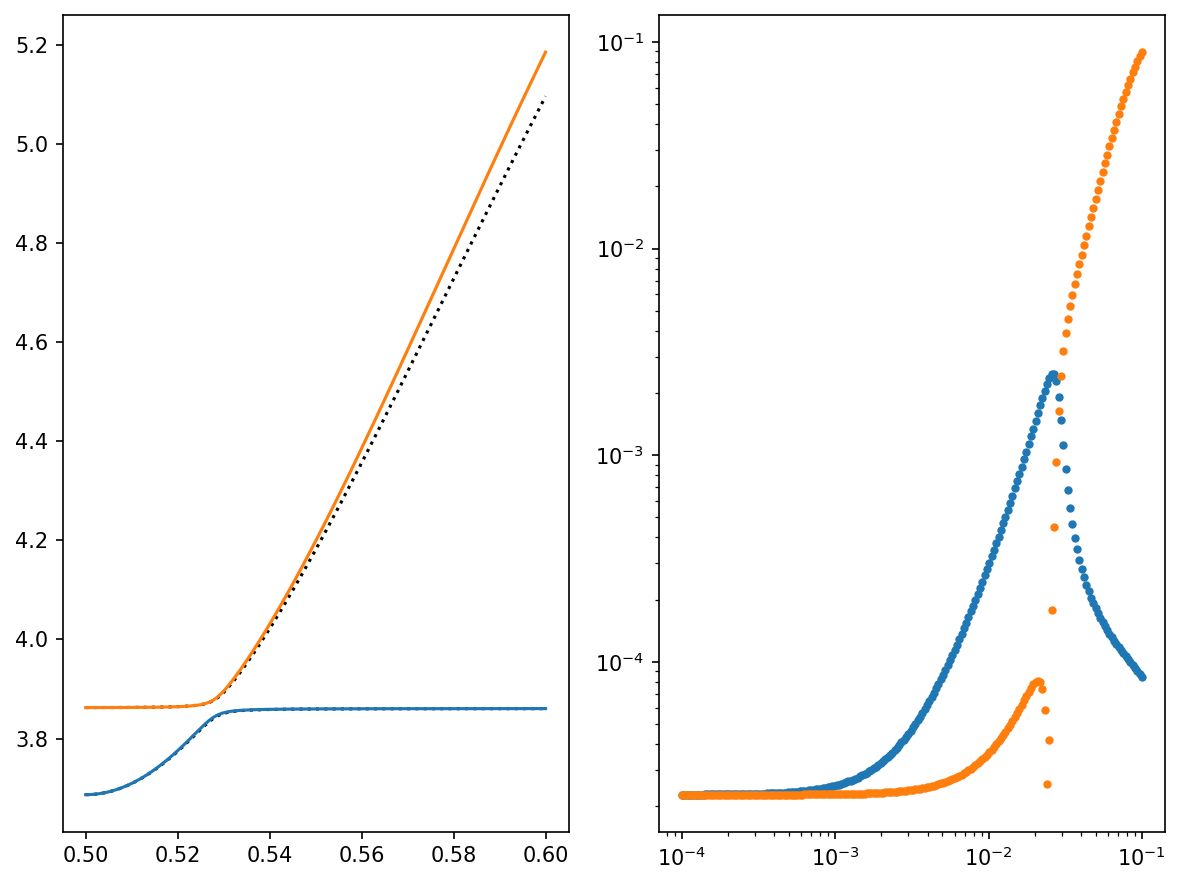

In [45]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=[8,6],dpi=150)

ax1.plot(φ_ext_values, E[:,1:3],':k')
ax1.plot(φ_ext_values, E_qo_vs_φ_ext[:,1:3])

ax2.plot(φ_ext_values-0.5, np.abs(E_qo_vs_φ_ext[:,1:3]-E[:,1:3]),'.')
ax2.set_yscale('log')
ax2.set_xscale('log')
fig.tight_layout()